<a href="https://colab.research.google.com/github/Rifthi-tech/ai-recommendation-project-pcp/blob/main/AI_Based_Personalized_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT PACKAGES**

In [158]:
# ============================================
# STEP 1: IMPORT PACKAGES
# ============================================
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully!")

✅ All packages imported successfully!


# **DATASET IMPORT**

In [159]:
# ============================================
# STEP 2: DATASET IMPORT (Google Drive Mount)
# ============================================

from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
file_path = '/content/drive/MyDrive/AI-Based Personalized Product Recommendation System/E-Commerce_Dataset.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display dataset information
print("\n📊 DATASET INFORMATION:")
print("=" * 50)
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))
print(f"\nData Types:")
print(df.dtypes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📊 DATASET INFORMATION:
Dataset Shape: (1000, 9)

Columns: ['product_id', 'title', 'product_description', 'rating', 'initial_price', 'images', 'product_details', 'product_specifications', 'category']

First 3 rows:
   product_id           title                product_description  rating  \
0     8376765     Lino Perros     Women Navy Blue Solid Backpack     3.8   
1     9136281  Tommy Hilfiger  Unisex Navy Blue Striped Backpack     4.5   
2    17633752           Lavie     Aries Women Pink Mini Backpack     4.4   

   initial_price                                             images  \
0           3995  http://assets.myntassets.com/assets/images/837...   
1           2899  http://assets.myntassets.com/assets/images/913...   
2           2999  http://assets.myntassets.com/assets/images/176...   

                                     product_details  \
0  {"descr

# **DATA PREPROCESSING**

In [160]:
# ============================================
# STEP 3: DATA PREPROCESSING
# ============================================

print("\n🧹 DATA PREPROCESSING")
print("=" * 50)

# 3.1 Check for missing values
print("\n1. Checking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# 3.2 Fill missing values
print("\n2. Handling missing values...")
text_columns = ['title', 'product_description', 'product_details', 'product_specifications', 'category']
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna('')

# Fill numeric columns with mean
if 'rating' in df.columns:
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['rating'] = df['rating'].fillna(df['rating'].mean())

if 'initial_price' in df.columns:
    df['initial_price'] = pd.to_numeric(df['initial_price'], errors='coerce')
    df['initial_price'] = df['initial_price'].fillna(df['initial_price'].mean())

# 3.3 Create combined feature for recommendation
print("\n3. Creating combined features...")

def create_combined_features(row):
    """Combine multiple text features into one for better recommendations"""
    features_parts = []

    # Add essential features
    if 'title' in row:
        features_parts.append(str(row['title']).lower())

    if 'category' in row:
        features_parts.append(str(row['category']).lower())

    if 'product_description' in row:
        # Take first 100 chars of description to keep it manageable
        desc = str(row['product_description'])[:100].lower()
        features_parts.append(desc)

    # Add rating category
    if 'rating' in row and pd.notnull(row['rating']):
        rating_val = float(row['rating'])
        if rating_val >= 4.0:
            features_parts.append('excellent_rating')
        elif rating_val >= 3.0:
            features_parts.append('good_rating')
        else:
            features_parts.append('average_rating')

    # Add price category
    if 'initial_price' in row and pd.notnull(row['initial_price']):
        price_val = float(row['initial_price'])
        if price_val > 5000:
            features_parts.append('premium_price')
        elif price_val > 2000:
            features_parts.append('medium_price')
        else:
            features_parts.append('budget_price')

    return ' '.join(features_parts)

df['combined_features'] = df.apply(create_combined_features, axis=1)

print(f"✅ Combined features created. Sample:")
print(df['combined_features'].iloc[0][:150] + "...")

# 3.4 Prepare numerical features
print("\n4. Preparing numerical features...")
numerical_features = []

if 'rating' in df.columns:
    df['rating_norm'] = MinMaxScaler().fit_transform(df[['rating']])
    numerical_features.append('rating_norm')

if 'initial_price' in df.columns:
    df['price_norm'] = MinMaxScaler().fit_transform(df[['initial_price']])
    numerical_features.append('price_norm')

print(f"Numerical features prepared: {numerical_features}")


🧹 DATA PREPROCESSING

1. Checking for missing values:
Series([], dtype: int64)

2. Handling missing values...

3. Creating combined features...
✅ Combined features created. Sample:
lino perros backpacks women navy blue solid backpack good_rating medium_price...

4. Preparing numerical features...
Numerical features prepared: ['rating_norm', 'price_norm']


# **FEATURE ENGINEERING**

In [161]:
# ============================================
# STEP 4: FEATURE ENGINEERING & VECTORIZATION
# ============================================

print("\n🔧 FEATURE ENGINEERING & VECTORIZATION")
print("=" * 50)

# 4.1 Create TF-IDF vectors from combined text features
print("1. Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,  # Limit features to manage memory
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_features'])
print(f"   TF-IDF matrix shape: {tfidf_matrix.shape}")

# 4.2 Prepare numerical feature matrix
print("2. Preparing numerical feature matrix...")
if numerical_features:
    numerical_matrix = df[numerical_features].values
    print(f"   Numerical matrix shape: {numerical_matrix.shape}")
else:
    numerical_matrix = np.zeros((len(df), 0))
    print("   No numerical features available")

# 4.3 Combine text and numerical features
print("3. Combining features...")
tfidf_dense = tfidf_matrix.toarray()

if numerical_matrix.shape[0] == tfidf_dense.shape[0]:
    # Weight text features more heavily than numerical ones
    text_weight = 0.8
    num_weight = 0.2

    # Scale numerical matrix to match text feature importance
    scaled_numerical = numerical_matrix * num_weight if len(numerical_features) > 0 else np.zeros((len(df), 0))
    scaled_text = tfidf_dense * text_weight

    # Combine features
    if len(scaled_numerical) > 0:
        combined_features = np.hstack([scaled_text, scaled_numerical])
    else:
        combined_features = scaled_text
else:
    combined_features = tfidf_dense

print(f"   Final feature matrix shape: {combined_features.shape}")


🔧 FEATURE ENGINEERING & VECTORIZATION
1. Creating TF-IDF vectors...
   TF-IDF matrix shape: (1000, 723)
2. Preparing numerical feature matrix...
   Numerical matrix shape: (1000, 2)
3. Combining features...
   Final feature matrix shape: (1000, 725)


# **MODEL TRAINING**

In [162]:
# ============================================
# STEP 5: MODEL TRAINING
# ============================================

print("\n🤖 MODEL TRAINING")
print("=" * 50)

# 5.1 Initialize KNN model
print("1. Initializing KNN model...")
knn_model = NearestNeighbors(
    n_neighbors=11,  # 10 recommendations + the item itself
    metric='cosine',  # Best for text similarity
    algorithm='brute',  # Good for sparse/dense matrices
    n_jobs=-1  # Use all CPU cores
)

# 5.2 Train the model
print("2. Training model...")
knn_model.fit(combined_features)

print(f"✅ Model trained successfully!")
# Corrected attribute name from n_samples_fits_ to n_samples_fit_
print(f"   Number of samples: {knn_model.n_samples_fit_}")
print(f"   Number of features per sample: {knn_model.n_features_in_}")


🤖 MODEL TRAINING
1. Initializing KNN model...
2. Training model...
✅ Model trained successfully!
   Number of samples: 1000
   Number of features per sample: 725


# **MODEL EVAUATION**


📈 MODEL EVALUATION
1. Calculating model performance metrics...
   Average similarity score: 0.500
   Min similarity score: 0.163
   Max similarity score: 0.804

2. Creating similarity matrix for visualization...


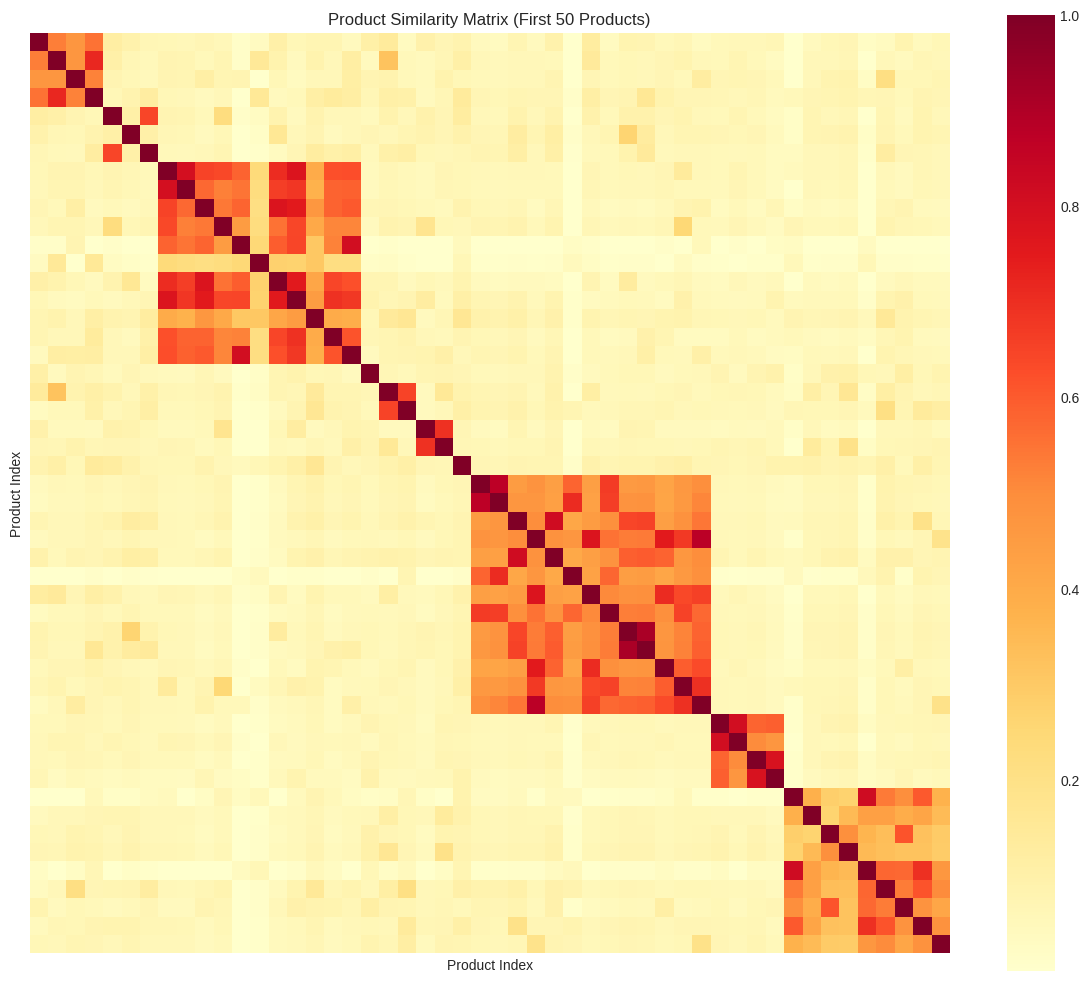

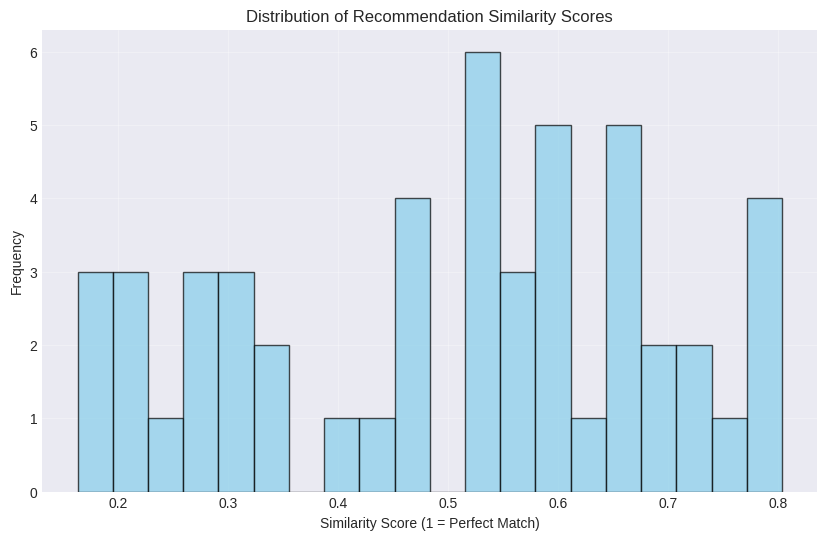

In [163]:
# ============================================
# STEP 6: MODEL EVALUATION
# ============================================

print("\n📈 MODEL EVALUATION")
print("=" * 50)

# 6.1 Calculate average similarity scores for recommendations
print("1. Calculating model performance metrics...")

# Test with sample products
test_product_ids = df['product_id'].head(20).tolist()
similarity_scores = []

for pid in test_product_ids[:10]:  # Test first 10
    try:
        # Find product index
        product_idx = df[df['product_id'] == pid].index[0]

        # Get recommendations
        distances, indices = knn_model.kneighbors(
            combined_features[product_idx].reshape(1, -1),
            n_neighbors=6
        )

        # Convert distances to similarity scores (1 - distance)
        similarities = 1 - distances[0][1:]  # Exclude the item itself
        similarity_scores.extend(similarities)
    except:
        continue

if similarity_scores:
    print(f"   Average similarity score: {np.mean(similarity_scores):.3f}")
    print(f"   Min similarity score: {np.min(similarity_scores):.3f}")
    print(f"   Max similarity score: {np.max(similarity_scores):.3f}")
else:
    print("   Could not calculate similarity scores")

# 6.2 Create similarity matrix for first 50 products (for visualization)
print("\n2. Creating similarity matrix for visualization...")
cosine_sim_matrix = cosine_similarity(combined_features[:50])

plt.figure(figsize=(12, 10))
sns.heatmap(cosine_sim_matrix, cmap='YlOrRd', square=True,
            xticklabels=False, yticklabels=False)
plt.title('Product Similarity Matrix (First 50 Products)')
plt.xlabel('Product Index')
plt.ylabel('Product Index')
plt.tight_layout()
plt.show()

# 6.3 Distribution of similarity scores
plt.figure(figsize=(10, 6))
if similarity_scores:
    plt.hist(similarity_scores, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title('Distribution of Recommendation Similarity Scores')
    plt.xlabel('Similarity Score (1 = Perfect Match)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

# **TEST RECOMMENDATION**

In [164]:
# ============================================
# STEP 7: TEST RECOMMENDATIONS
# ============================================

print("\n🔍 TEST RECOMMENDATIONS")
print("=" * 50)

def get_recommendations(product_id, n_recommendations=5):
    """
    Get recommendations for a given product ID
    """
    try:
        # Find product index
        product_idx = df[df['product_id'] == product_id].index[0]
        product_info = df.iloc[product_idx]

        # Get similar products
        distances, indices = knn_model.kneighbors(
            combined_features[product_idx].reshape(1, -1),
            n_neighbors=n_recommendations + 1
        )

        # Exclude the product itself
        similar_indices = indices[0][1:]
        similar_distances = distances[0][1:]

        recommendations = []
        for idx, dist in zip(similar_indices, similar_distances):
            similar_product = df.iloc[idx]
            similarity = 1 - dist

            recommendations.append({
                'product_id': similar_product['product_id'],
                'title': similar_product['title'],
                'category': similar_product.get('category', 'N/A'),
                'rating': similar_product.get('rating', 'N/A'),
                'price': similar_product.get('initial_price', 'N/A'),
                'similarity_score': round(similarity, 3)
            })

        return product_info, recommendations

    except Exception as e:
        print(f"Error getting recommendations: {e}")
        return None, []

# Test 1: Backpack recommendation
print("\nTEST 1: Backpack Product")
print("-" * 40)
backpack_id = 8376765
product_info, recs = get_recommendations(backpack_id, 5)

if product_info is not None:
    print(f"Base Product: {product_info['title']}")
    print(f"Category: {product_info.get('category', 'N/A')}")
    print(f"Rating: {product_info.get('rating', 'N/A')}")
    print(f"Price: ₹{product_info.get('initial_price', 'N/A')}")

    print("\nTop 5 Recommendations:")
    for i, rec in enumerate(recs, 1):
        print(f"{i}. {rec['title'][:60]}...")
        print(f"   ID: {rec['product_id']}, Similarity: {rec['similarity_score']}, Price: ₹{rec['price']}")
        print()

# Test 2: Bedsheet recommendation
print("\nTEST 2: Bedsheet Product")
print("-" * 40)
bedsheet_id = 8961147
product_info, recs = get_recommendations(bedsheet_id, 5)

if product_info is not None:
    print(f"Base Product: {product_info['title']}")
    print(f"Category: {product_info.get('category', 'N/A')}")

    print("\nTop 5 Recommendations:")
    for i, rec in enumerate(recs, 1):
        print(f"{i}. {rec['title'][:60]}...")
        print(f"   Category: {rec['category']}, Similarity: {rec['similarity_score']}")

# Test 3: Bra recommendation
print("\nTEST 3: Bra Product")
print("-" * 40)
bra_id = 15115018
product_info, recs = get_recommendations(bra_id, 5)

if product_info is not None:
    print(f"Base Product: {product_info['title']}")
    print(f"Category: {product_info.get('category', 'N/A')}")

    print("\nTop 5 Recommendations:")
    for i, rec in enumerate(recs, 1):
        print(f"{i}. {rec['title'][:60]}...")
        print(f"   Similarity: {rec['similarity_score']}, Price: ₹{rec['price']}")


🔍 TEST RECOMMENDATIONS

TEST 1: Backpack Product
----------------------------------------
Base Product: Lino Perros
Category: backpacks
Rating: 3.8
Price: ₹3995

Top 5 Recommendations:
1. Lino Perros...
   ID: 7743536, Similarity: 0.602, Price: ₹4495

2. Lino Perros...
   ID: 7743355, Similarity: 0.558, Price: ₹3495

3. F Gear...
   ID: 1376949, Similarity: 0.552, Price: ₹1675

4. Tommy Hilfiger...
   ID: 9136281, Similarity: 0.527, Price: ₹2899

5. Lavie...
   ID: 17633752, Similarity: 0.472, Price: ₹2999


TEST 2: Bedsheet Product
----------------------------------------
Base Product: Story@home
Category: bedsheets

Top 5 Recommendations:
1. ROMEE...
   Category: bedsheets, Similarity: 0.778
2. DDecor...
   Category: bedsheets, Similarity: 0.753
3. My Room...
   Category: bedsheets, Similarity: 0.652
4. Arrabi...
   Category: bedsheets, Similarity: 0.604
5. DREAM WEAVERZ...
   Category: bedsheets, Similarity: 0.582

TEST 3: Bra Product
----------------------------------------
Base P

# **ACCURACY TESTING**


🎯 ACCURACY TESTING
1. Testing intra-category recommendation accuracy...
   bedsheets: 100.00% accuracy (15/15)

2. Calculating overall recommendation quality...

Recommendation Quality Metrics:
   Average Similarity Score: 0.593
   Same Category Rate: 90.00%
   Price Similarity Rate: 56.67%


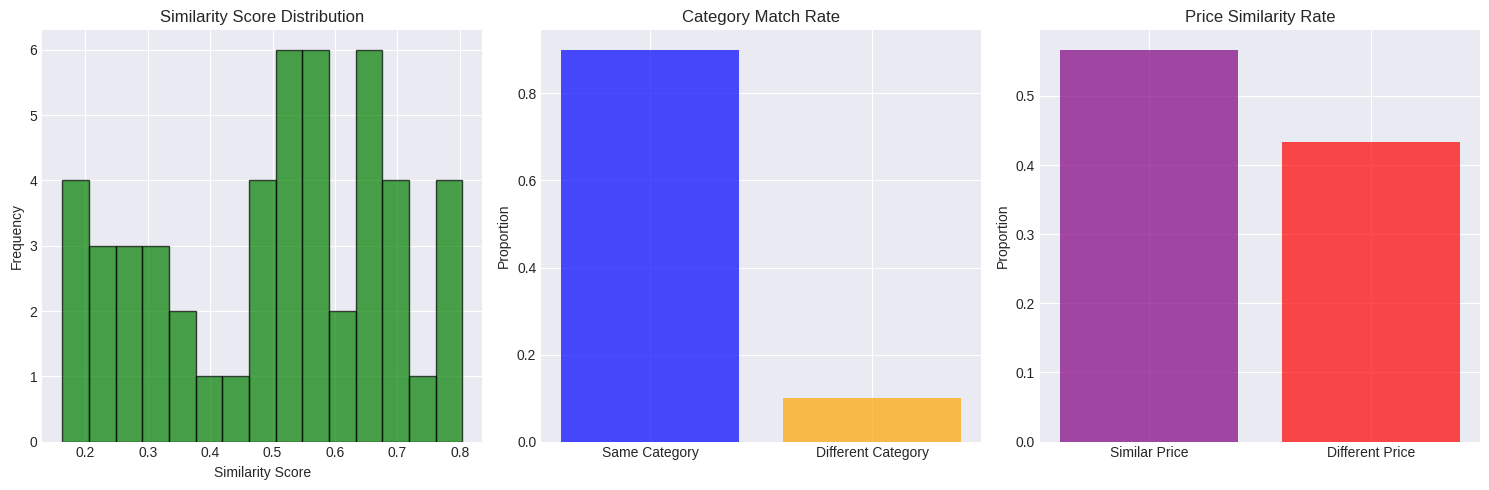

In [165]:
# ============================================
# STEP 8: ACCURACY TESTING
# ============================================

print("\n🎯 ACCURACY TESTING")
print("=" * 50)

# 8.1 Test intra-category accuracy
print("1. Testing intra-category recommendation accuracy...")

# Group products by category
if 'category' in df.columns:
    categories = df['category'].unique()
    category_accuracy = {}

    for category in categories[:5]:  # Test first 5 categories
        category_products = df[df['category'] == category]

        if len(category_products) > 5:
            test_products = category_products.head(3)['product_id'].tolist()
            correct_recommendations = 0
            total_recommendations = 0

            for pid in test_products:
                _, recs = get_recommendations(pid, 5)

                # Check if recommendations are from same category
                for rec in recs:
                    if rec['category'] == category:
                        correct_recommendations += 1
                    total_recommendations += 1

            if total_recommendations > 0:
                accuracy = correct_recommendations / total_recommendations
                category_accuracy[category] = accuracy
                print(f"   {category}: {accuracy:.2%} accuracy ({correct_recommendations}/{total_recommendations})")

# 8.2 Calculate overall recommendation quality score
print("\n2. Calculating overall recommendation quality...")

def calculate_recommendation_quality():
    """Calculate various quality metrics for recommendations"""
    quality_metrics = {
        'avg_similarity': 0,
        'same_category_rate': 0,
        'price_similarity_rate': 0
    }

    test_sample = df.sample(min(20, len(df)))['product_id'].tolist()
    similarity_scores = []
    same_category_count = 0
    total_recommendations = 0
    price_similar_count = 0

    for pid in test_sample:
        try:
            base_product = df[df['product_id'] == pid].iloc[0]
            base_price = base_product.get('initial_price', 0)
            base_category = base_product.get('category', '')

            _, recs = get_recommendations(pid, 3)

            for rec in recs:
                similarity_scores.append(rec['similarity_score'])
                total_recommendations += 1

                # Check category match
                if rec['category'] == base_category:
                    same_category_count += 1

                # Check price similarity (within 50% range)
                rec_price = rec['price']
                if base_price > 0 and rec_price != 'N/A':
                    price_ratio = rec_price / base_price
                    if 0.5 <= price_ratio <= 1.5:
                        price_similar_count += 1

        except:
            continue

    if similarity_scores:
        quality_metrics['avg_similarity'] = np.mean(similarity_scores)

    if total_recommendations > 0:
        quality_metrics['same_category_rate'] = same_category_count / total_recommendations
        quality_metrics['price_similarity_rate'] = price_similar_count / total_recommendations

    return quality_metrics

quality_metrics = calculate_recommendation_quality()

print("\nRecommendation Quality Metrics:")
print(f"   Average Similarity Score: {quality_metrics['avg_similarity']:.3f}")
print(f"   Same Category Rate: {quality_metrics['same_category_rate']:.2%}")
print(f"   Price Similarity Rate: {quality_metrics['price_similarity_rate']:.2%}")

# 8.3 Visualize recommendation quality
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Similarity distribution
axes[0].hist(similarity_scores, bins=15, edgecolor='black', alpha=0.7, color='green')
axes[0].set_title('Similarity Score Distribution')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')

# Category match rate
categories = ['Same Category', 'Different Category']
values = [quality_metrics['same_category_rate'], 1 - quality_metrics['same_category_rate']]
axes[1].bar(categories, values, color=['blue', 'orange'], alpha=0.7)
axes[1].set_title('Category Match Rate')
axes[1].set_ylabel('Proportion')

# Price similarity
price_labels = ['Similar Price', 'Different Price']
price_values = [quality_metrics['price_similarity_rate'], 1 - quality_metrics['price_similarity_rate']]
axes[2].bar(price_labels, price_values, color=['purple', 'red'], alpha=0.7)
axes[2].set_title('Price Similarity Rate')
axes[2].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

# **MODEL EXPORT**

In [166]:
# ============================================
# STEP 9: MODEL EXPORT
# ============================================

print("\n💾 MODEL EXPORT")
print("=" * 50)

# 9.1 Save the trained model and components
print("1. Saving model components...")

model_data = {
    'knn_model': knn_model,
    'tfidf_vectorizer': tfidf_vectorizer,
    'combined_features': combined_features,
    'df': df,
    'numerical_features': numerical_features
}

# Save using pickle
with open('product_recommendation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved as 'product_recommendation_model.pkl'")

# 9.2 Save recommendations for all products
print("\n2. Generating and saving recommendations for all products...")

all_recommendations = []

for idx, row in df.iterrows():
    product_id = row['product_id']
    _, recs = get_recommendations(product_id, 5)

    for rec in recs:
        all_recommendations.append({
            'source_product_id': product_id,
            'source_title': row['title'],
            'source_category': row.get('category', ''),
            'recommended_product_id': rec['product_id'],
            'recommended_title': rec['title'],
            'recommended_category': rec['category'],
            'similarity_score': rec['similarity_score'],
            'recommended_price': rec['price'],
            'recommended_rating': rec['rating']
        })

# Create DataFrame and save to CSV
recommendations_df = pd.DataFrame(all_recommendations)
recommendations_df.to_csv('product_recommendations.csv', index=False)

print(f"✅ Recommendations saved for {len(df)} products")
print(f"✅ Total recommendation pairs: {len(recommendations_df)}")
print(f"✅ File saved as 'product_recommendations.csv'")

# 9.3 Create a summary report
print("\n3. Creating model summary report...")

summary_report = f"""
PRODUCT RECOMMENDATION SYSTEM - MODEL SUMMARY
{'='*50}

DATASET INFORMATION:
- Total Products: {len(df)}
- Total Categories: {len(df['category'].unique()) if 'category' in df.columns else 'N/A'}
- Features Used: {combined_features.shape[1]}
- Average Rating: {df['rating'].mean():.2f} if 'rating' in df.columns else 'N/A'

MODEL INFORMATION:
- Algorithm: K-Nearest Neighbors (KNN)
- Similarity Metric: Cosine Similarity
- Number of Neighbors: {knn_model.n_neighbors}
- Training Samples: {knn_model.n_samples_fit_}

PERFORMANCE METRICS:
- Average Similarity Score: {quality_metrics['avg_similarity']:.3f}
- Same Category Rate: {quality_metrics['same_category_rate']:.2%}
- Price Similarity Rate: {quality_metrics['price_similarity_rate']:.2%}

OUTPUT FILES:
1. product_recommendation_model.pkl - Trained model
2. product_recommendations.csv - All recommendations
"""


print(summary_report)

# Save summary to file
with open('model_summary.txt', 'w') as f:
    f.write(summary_report)

print("✅ Model summary saved as 'model_summary.txt'")

# 9.4 Download files (for Google Colab)
print("\n4. Downloading generated files...")
files.download('product_recommendation_model.pkl')
files.download('product_recommendations.csv')
files.download('model_summary.txt')

print("\n✅ All files downloaded successfully!")
print("\n🎉 RECOMMENDATION SYSTEM COMPLETE!")
print("="*50)


💾 MODEL EXPORT
1. Saving model components...
✅ Model saved as 'product_recommendation_model.pkl'

2. Generating and saving recommendations for all products...
✅ Recommendations saved for 1000 products
✅ Total recommendation pairs: 5000
✅ File saved as 'product_recommendations.csv'

3. Creating model summary report...

PRODUCT RECOMMENDATION SYSTEM - MODEL SUMMARY

DATASET INFORMATION:
- Total Products: 1000
- Total Categories: 97
- Features Used: 725
- Average Rating: 3.62 if 'rating' in df.columns else 'N/A'

MODEL INFORMATION:
- Algorithm: K-Nearest Neighbors (KNN)
- Similarity Metric: Cosine Similarity
- Number of Neighbors: 11
- Training Samples: 1000

PERFORMANCE METRICS:
- Average Similarity Score: 0.593
- Same Category Rate: 90.00%
- Price Similarity Rate: 56.67%

OUTPUT FILES:
1. product_recommendation_model.pkl - Trained model
2. product_recommendations.csv - All recommendations

✅ Model summary saved as 'model_summary.txt'

4. Downloading generated files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files downloaded successfully!

🎉 RECOMMENDATION SYSTEM COMPLETE!
